# Voting Prediction

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

1. Baixe os dados aqui (veja descrição dos dados mais abaixo).
2. Considere o pipeline mostrado nesse link (Links para um site externo)Links para um site externo para construir seus modelos de regressão. Isso implica, dentre outras coisas:

    2.1 Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.
    
    2.2 Construir modelos de regressão com (ridge e lasso) e sem regularização.
    
    2.3 Considerar também modelos de regressão não paramétrica como K-NN.
    
    2.4 Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).
    
    2.5 Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.
    
    2.6 Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.
    
3. Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.

    Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.
    
4. Responder:

    4.1. Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.


# Introduction

This assessment was divided into three steps:

1. Data preparation and feature engineering step
2. Model construction
3. Conclusion

First, the dataset was analyzed and prepared to be used in the following step. In the second step, the models were built and applied to the 2014 election dataset. Finally, we summarize the result achieved by the models. 

## 1. Data preparation and feature engineering step

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

To enable the model use 

In [5]:
data = pd.read_csv("eleicoes_2006_a_2010.csv")
data2014 = pd.read_csv("eleicoes_2014.csv")

data = pd.concat([data,data2014])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12266 entries, 0 to 4935
Data columns (total 23 columns):
ano                                      12266 non-null int64
sequencial_candidato                     12266 non-null int64
nome                                     12266 non-null object
uf                                       12266 non-null object
partido                                  12266 non-null object
quantidade_doacoes                       12266 non-null int64
quantidade_doadores                      12266 non-null int64
total_receita                            12105 non-null float64
media_receita                            12105 non-null float64
recursos_de_outros_candidatos/comites    8131 non-null float64
recursos_de_pessoas_fisicas              8374 non-null float64
recursos_de_pessoas_juridicas            5068 non-null float64
recursos_proprios                        7802 non-null float64
quantidade_despesas                      12266 non-null int64
quantidade_fo

First, some features that we think that has no impact to the voters, for instance, name, civil state, and occupation. And since the dataset has only information about 'DEPUTADO FEDERAL' the feature cargo was removed. 

In [6]:
#separar por ano
data = data.drop(['nome','sequencial_candidato','cargo','grau','estado_civil','ocupacao'],axis=1)

Before we start to normalize the features, it is important to find correlated features.  Since correlated features, in general, don't improve the machine learning models. 

In [7]:
def plotCorrelation(df,vm=0.7):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap='viridis'

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=vm, center=0,
                square=True, linewidths=.5,
                #annot=True, 
                #fmt="g",
                cbar_kws={"shrink": .5}
               )


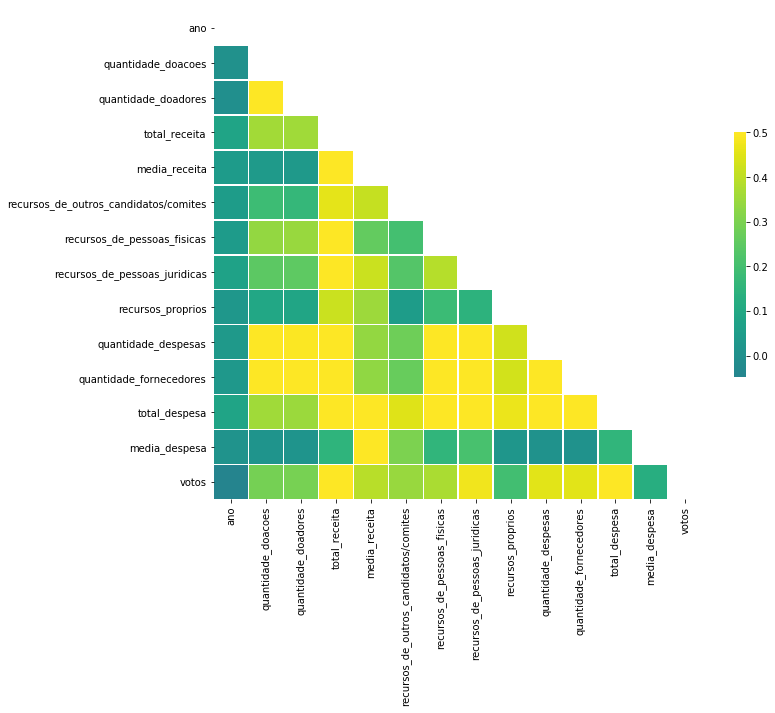

In [8]:
plotCorrelation(data,vm=0.5)

As shown in the previous figure, the features ('recursos_de_outros_candidatos/comites' ,'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas', 'recursos_proprios' and 'quantidade_doadores') are highly correlated with total_receita, and for that reason, we remove these features from our data.

In [9]:
data = data.drop(['recursos_de_outros_candidatos/comites',
           'recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas',
           'recursos_proprios',
           'quantidade_doadores'],axis=1)

In the new correlation heat map (plotted below), we can see that the highly correlated features were removed from the data.

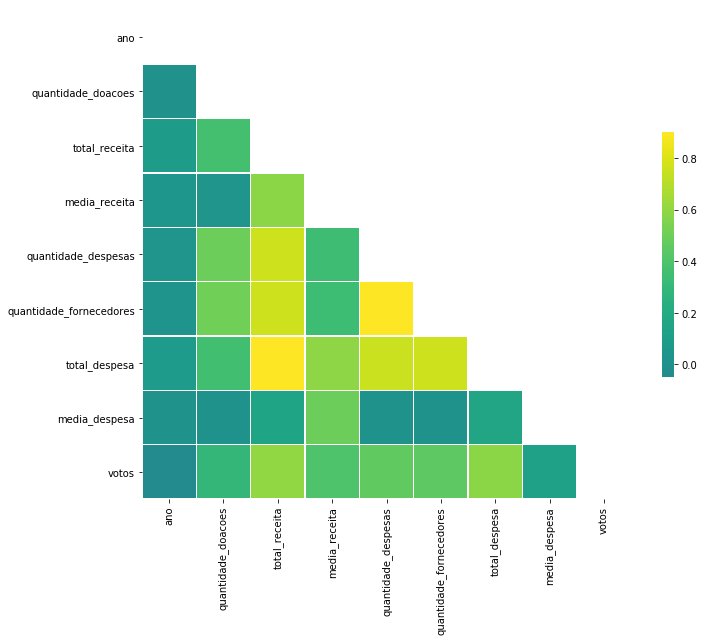

In [10]:
plotCorrelation(data,vm=0.9)

As shown in the table below, seven features need to be normalized. 

In [11]:
df = data.dropna()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ano,12105.0,2010.564725,3.235976,2006.0,2006.000000,2010.000000,2014.000000,2014.00
quantidade_doacoes,12105.0,25.622635,96.412300,1.0,4.000000,9.000000,22.000000,6997.00
total_receita,12105.0,173273.085288,457893.486330,0.0,2838.930000,11800.130000,89126.200000,5836139.50
media_receita,12105.0,5750.422579,14174.233933,0.0,614.428571,1490.308333,4635.384615,500180.00
quantidade_despesas,12105.0,136.966378,426.588469,1.0,6.000000,18.000000,75.000000,9932.00
quantidade_fornecedores,12105.0,110.977117,341.702411,1.0,5.000000,16.000000,63.000000,8359.00
total_despesa,12105.0,175151.662170,466253.955013,0.0,2810.000000,11797.640000,89601.050000,7420178.58
media_despesa,12105.0,1434.163495,5091.225198,0.0,422.128571,815.000000,1536.691525,500177.00
votos,12105.0,20092.115985,46846.575159,0.0,674.000000,2323.000000,14840.000000,1524361.00


To increase the accuracy of the model's the elections results will be divided into two groups (South, Southeast states and North, Northeast states).

In [12]:
N = ['AC','AM','AP','PA','RO','RR','TO']
NE = ['AL','BA','CE','MA','MA','PB','PE','PI','RN']
CO = ['GO','MS','MT']
SE = ['ES','MG','RJ','SP']
S = ['PR','RS','SC']

df['regiao'] = np.where(df['uf'].isin(N+NE),'NNE','SSE')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12105 entries, 0 to 4935
Data columns (total 13 columns):
ano                        12105 non-null int64
uf                         12105 non-null object
partido                    12105 non-null object
quantidade_doacoes         12105 non-null int64
total_receita              12105 non-null float64
media_receita              12105 non-null float64
quantidade_despesas        12105 non-null int64
quantidade_fornecedores    12105 non-null int64
total_despesa              12105 non-null float64
media_despesa              12105 non-null float64
sexo                       12105 non-null object
votos                      12105 non-null int64
regiao                     12105 non-null object
dtypes: float64(4), int64(5), object(4)
memory usage: 1.3+ MB


Dummifing the features and normalizing the features

In [14]:
#dummify
ddf = df.drop(['uf'],axis=1)

features = ['quantidade_doacoes','total_receita','media_receita','quantidade_despesas','quantidade_fornecedores',
'total_despesa','media_despesa','votos']

#normalizing skew
for feature in features:
    ddf[feature] = np.log1p(ddf[feature])
    
ddf = pd.get_dummies(ddf)

The  2014 voting result, will be used to the final test. The 2006 and 2010 voting result will be employed to the model adjustments. 

In [15]:
df2014 = ddf.loc[ddf['ano'] == 2014]
ddf = ddf.loc[ddf['ano'] != 2014]

ddf = ddf.drop(['ano'],axis=1)
df2014 = df2014.drop(['ano'],axis=1)

In [16]:
#dfa
Y = ddf.pop('votos')
X_train, X_validation, Y_train, Y_validation = train_test_split(ddf, Y, test_size=0.2)

Y14 = df2014.pop('votos')
Xt_14, Xv_14, Yt_14, Yv_14 = train_test_split(df2014, Y14, test_size=0.2)

## 2. Model construction

To predict the election result, we use the following approaches:

1. Ridge Regression
2. Lasso Regression
3. K-nn
4. Linear SVM Regression

In [17]:
from sklearn.linear_model import Ridge, Lasso , LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def rmse_cv(model,Xtrain,Ytrain):
    rmse = np.sqrt(-cross_val_score(model, Xtrain, Ytrain, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("rmse")

def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin()
    return(best_rmse, best_param)

def plot_data(X,Y):    
    plt.plot(X,Y,'k.')
    plt.xlabel('X')
    plt.ylabel('Y')

def plot_residuals_vs_fit(X,Y, model, title):
    y_pred = model.predict(X)
    res = Y - y_pred
    #res = np.log(Y - y_pred)
    plt.plot(y_pred,res,'k.',color='blue',)
    plt.axhline(y=0., color='r', linestyle='-')
    plt.xlabel("predictions")
    plt.ylabel("residuals")
    plt.title(title)
    #plt.yscale('log')
    
def print_poly_predictions(X,Y, model):
    plot_data(X,Y)
    #x_plot = np.array([i/200.0 for i in range(200)])
    #X_plot = x_plot[:,np.newaxis]
    y_pred = model.predict(X)
    plt.plot(X,y_pred,'g.')
    #plt.axis([0,1,-1.5,2])

def print_coefficients(model):
    w = list(model.coef_)
    w.reverse()
    print (np.poly1d(w) + model.intercept_)
    
def show_results(title,model,best_alpha,X,Y,ret=False):
    y_pred = model.predict(X)
    plot_residuals_vs_fit(X, Y, model,title)
    print("Results")
    if best_alpha != None:
        print("\t Best alpha: %.2f" % best_alpha)
    print("\t Mean squared error: %.2f" % mean_squared_error(Y,y_pred))
    print('\t Variance score: %.2f' % r2_score(Y,y_pred))
    
    if ret:
        return [title,mean_squared_error(Y,y_pred),r2_score(Y,y_pred)]

### 2.1 Ridge Regression

Knowing that the RidgeRegession is described by the equation: 

$||y - Xw||^2_2 + alpha * ||w||^2_2$

We can build a no regularized model setting the alpha = 0.

In [18]:
RidgeModel = Ridge(alpha=0)
RidgeModel.fit(X_train, Y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
print_coefficients(RidgeModel)

           46             45             44             43
1.726e+12 x  + 1.726e+12 x  + 6.124e+12 x  + 6.124e+12 x 
              42             41             40             39
 + 4.228e+13 x  + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x 
              38             37             36             35
 + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x 
              34             33             32             31
 + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x 
              30             29             28             27
 - 1.328e+13 x  + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x 
              26             25             24             23
 + 3.733e+12 x  - 6.124e+12 x  + 3.733e+12 x  + 3.733e+12 x 
              22             21             20             19
 + 3.733e+12 x  + 3.733e+12 x  + 3.919e+13 x  + 3.733e+12 x 
              18             17             16             15
 + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x  + 3.733e+12 x 
              14      

The model achieved a low RMSE (**1.07**) and is **73** *percent* explained by R²). As illustrated in the plot below the residue is randomly distributed, and near from zero.

In [23]:
#print_poly_predictions(X_train,Y_train,model)

Results
	 Mean squared error: 1.07
	 Variance score: 0.73


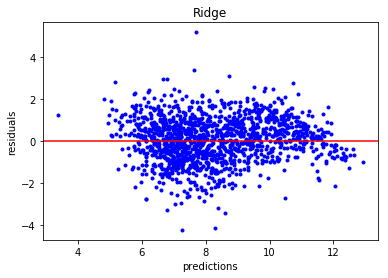

In [24]:
show_results("Ridge",RidgeModel,None,X_validation,Y_validation)

### 2.2 Lasso Regression

Building the lasso regularized ($0 < alphas < 10$) Lasso regression

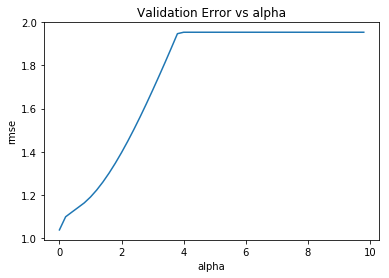

In [26]:
alphas = np.linspace(0,10,50,endpoint=False)
cv_lasso_rmse = [rmse_cv(Lasso(alpha = alpha), X_train,Y_train).mean() 
            for alpha in alphas ]

series_lasso = pd.Series(cv_lasso_rmse, index = alphas)
plot_rmse_param(series_lasso, "alpha")

The best regularized Lasso Regression is shown below.

In [27]:
best_rmse, best_alpha = best_rmse_param(series_lasso)
best_LassoModel = Lasso(alpha = best_alpha)
best_LassoModel.fit(X_train, Y_train)

print_coefficients(best_LassoModel)

           46          45             44          43           41
1.111e-14 x  + 0.2772 x  + 1.137e-14 x  - 0.4739 x  + 0.05204 x 
           40          39          38           37          36
 - 0.4221 x  - 0.3686 x  - 0.1265 x  + 0.06952 x  + 0.2456 x 
           35           34           33          32          31
 + 0.1299 x  - 0.04404 x  - 0.07032 x  - 0.3623 x  + 0.2189 x 
           29            28          27          26          24
 + 0.1005 x  - 0.009801 x  - 0.5542 x  - 0.4039 x  + 0.3891 x 
          23          22            21          19          18
 - 0.152 x  + 0.1326 x  + 0.003684 x  + 0.0931 x  - 0.2254 x 
           17          16          15          14          12
 + 0.2559 x  + 0.2057 x  - 0.2892 x  + 0.5401 x  + 0.2197 x 
          11           10           9          8           7         6
 - 0.371 x  + 0.08315 x  - 0.09373 x + 0.1876 x + 0.09634 x + 1.391 x
          5         4        3           2
 - 1.325 x + 1.453 x + 0.23 x + 0.08445 x + 0.2965 x + 2.5

The model achieved (with no regularization, $alpha = 0$) a low RMSE (**1.08**) and is **73** *percent* explained by R²( the same as the Ridge Regression). As illustrated in the plot below the residue is randomly distributed, and near from zero.

Results
	 Best alpha: 0.00
	 Mean squared error: 1.08
	 Variance score: 0.73


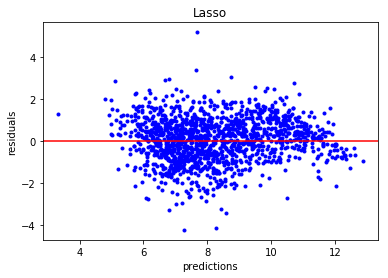

In [28]:
show_results("Lasso",best_LassoModel,best_alpha,X_validation,Y_validation)

### 2.3 K-nn

Building the KNeighborsRegressor ($2 < k < 30$)

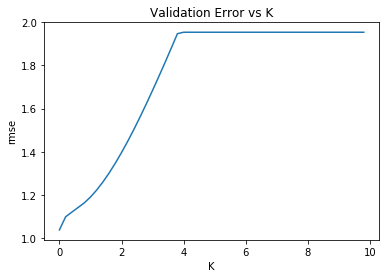

In [29]:
from sklearn.neighbors import KNeighborsRegressor

K = range(2,30)
cv_knn_rmse = [rmse_cv(KNeighborsRegressor(n_neighbors = k), X_train,Y_train).mean() 
            for k in K ]

series_knn = pd.Series(cv_knn_rmse, index = K)
plot_rmse_param(series_lasso, "K")

The model achieved (with $k = 29$) a low RMSE (**0.99**) and is **75** *percent* explained by R². As illustrated in the plot below the residue is randomly distributed, and near from zero.

Results
	 Best alpha: 29.00
	 Mean squared error: 0.99
	 Variance score: 0.75


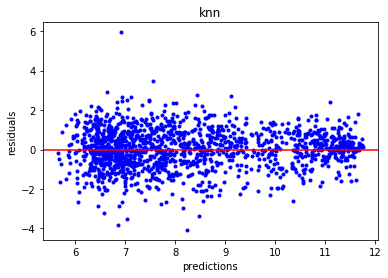

In [30]:
best_rmse, best_k = best_rmse_param(series_knn)
best_knn = KNeighborsRegressor(n_neighbors = best_k)
best_knn.fit(X_train, Y_train)

show_results("knn",best_knn,best_k,X_validation,Y_validation)

### 2.4 SVR

As a new regression method, we chose de LinearSVR.

Results
	 Mean squared error: 1.11
	 Variance score: 0.72


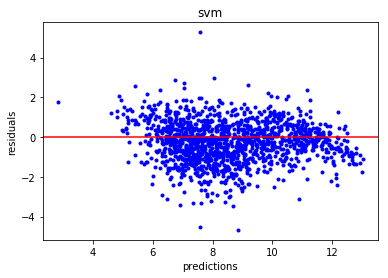

In [31]:
from sklearn.svm import LinearSVR
lsvr = LinearSVR(random_state=0, tol=1e-5)
lsvr.fit(X_validation, Y_validation)

show_results("svm",lsvr,None,X_validation,Y_validation)

The model achieved a low RMSE (**1.11**) and is **72** *percent* explained by R². As illustrated in the plot below the residue is randomly distributed, and near from zero.

## 3. Conclusion

In this section, we plot the result of the original model (trained with the 2006 and 2010 dataset) and in a retrained model (trained with the 2014 dataset). 

### 3.1 Ridge Model

The **original model** failed to predict the election results since the mode achieves a high RMSE and R².

Results
	 Mean squared error: 47090662893638453460729856.00
	 Variance score: -6586791053422158990540800.00


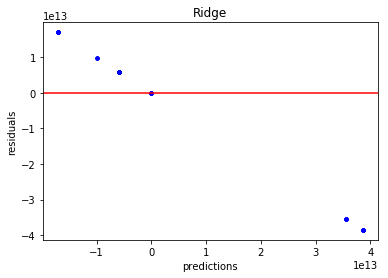

In [32]:
results = []

data = show_results("Ridge",RidgeModel,None,Xv_14, Yv_14,ret=True)
results.append(data)

The **retrained model** achieved (with the same parameters of the original model) aRMSE of **3.24** and is **53** *percent* explained by R². As illustrated in the plot below the residue is randomly distributed, and near from zero.

Results
	 Mean squared error: 3.29
	 Variance score: 0.54


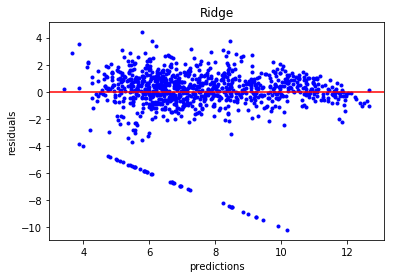

In [33]:
results14 = []

RidgeModel14 = Ridge()
RidgeModel14.fit(Xt_14,Yt_14)

data = show_results("Ridge",RidgeModel14,None,Xv_14, Yv_14,ret=True)
results14.append(data)

### 3.2 Lasso Regression

#### 3.2.1 Original

Results
	 Mean squared error: 3.88
	 Variance score: 0.46


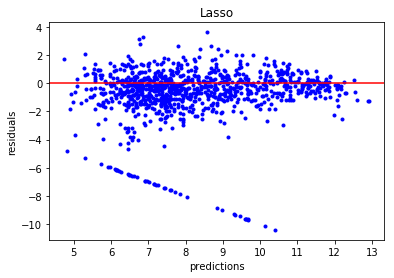

In [34]:
data = show_results("Lasso",best_LassoModel,None,Xv_14, Yv_14,ret=True)
results.append(data)

#### 3.2.2 Retrained Model

Results
	 Mean squared error: 3.29
	 Variance score: 0.54


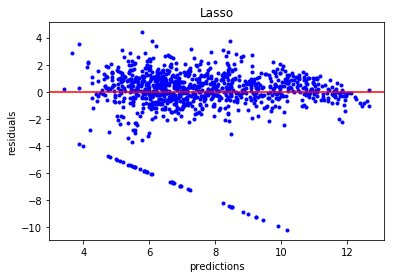

In [35]:
Lasso14 = Lasso()
Lasso14.fit(Xt_14,Yt_14)
data = show_results("Lasso",RidgeModel14,None,Xv_14, Yv_14,ret=True)
results14.append(data)

The **original model** and the **retrained model** achieved similar RMSE (**3.88 and 3.29 respectively**) and is **46** and **54** (respectively) *percent* explained by R². As illustrated in the plot below the residue is randomly distributed, and near from zero.

### 3.3 knn

#### 3.3.1 Original Model

Results
	 Mean squared error: 3.92
	 Variance score: 0.45


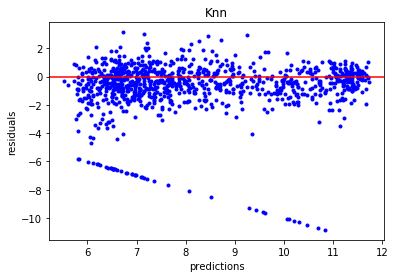

In [36]:
data = show_results("Knn",best_knn,None,Xv_14, Yv_14,ret=True)
results.append(data)

#### 3.3.2 Retrained Model

Results
	 Mean squared error: 3.29
	 Variance score: 0.54


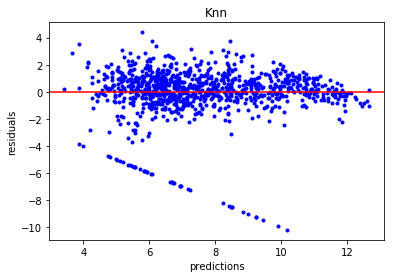

In [37]:
knn14 = KNeighborsRegressor(n_neighbors = best_k)
knn14.fit(Xt_14,Yt_14)
data = show_results("Knn",RidgeModel14,None,Xv_14, Yv_14,ret=True)
results14.append(data)

The **original model** and the **retrained model** achieved similar RMSE (**3.88 and 3.29 respectively**) and is **46** and **54** (respectively) *percent* explained by R². As illustrated in the plot below the residue is randomly distributed, and near from zero.

### 3.4 SVM

#### 3.4.1 Original Model

Results
	 Mean squared error: 4.44
	 Variance score: 0.38


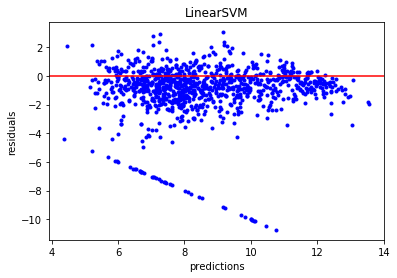

In [38]:
data = show_results("LinearSVM",lsvr,None,Xv_14, Yv_14,ret=True)
results.append(data)

#### 3.4.2 Retrained model

Results
	 Mean squared error: 3.29
	 Variance score: 0.54


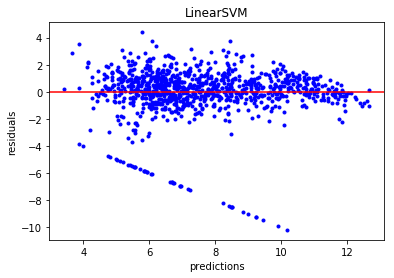

In [40]:
lsvr14 = LinearSVR(random_state=0, tol=1e-5)
lsvr14.fit(Xt_14,Yt_14)
data = show_results("LinearSVM",RidgeModel14,None,Xv_14, Yv_14,ret=True)
results14.append(data)

The **original model** and the **retrained model** achieved similar RMSE (**4.44 and 3.29 respectively**) and is **38** and **54** (respectively) *percent* explained by R². As illustrated in the plot below the residue is randomly distributed, and near from zero.

### 3.5 Results

In this section we compare the results of the models.

In [54]:
labels = ["algotihm","RMSE","R2"]
rdf = pd.DataFrame.from_records(results,columns=labels)
rdf14 = pd.DataFrame.from_records(results14,columns=labels)

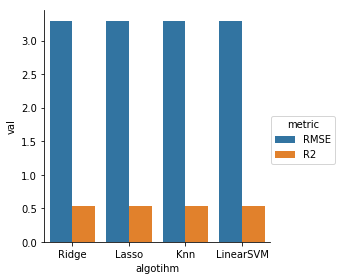

In [55]:
sns.factorplot(x='algotihm', y='val', hue='metric', 
               data=rdf14.melt('algotihm', var_name='metric', value_name='val'), kind='bar')

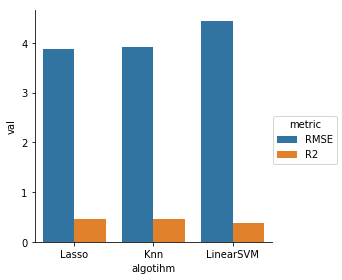

In [58]:
z = rdf[rdf['algotihm']!='Ridge']
sns.factorplot(x='algotihm', y='val', hue='metric', 
               data=z.melt('algotihm', var_name='metric', value_name='val'), kind='bar')

In [43]:
rdf['retrained'] = 'No'
rdf14['retrained'] = 'Yes'
pd.concat([rdf,rdf14]).sort_values(by=['algotihm'])

,algotihm,RMSE,R2,retrained
2,Knn,3.919336e+00,4.517841e-01,No
2,Knn,3.292835e+00,5.394158e-01,Yes
1,Lasso,3.875103e+00,4.579712e-01,No
1,Lasso,3.292835e+00,5.394158e-01,Yes
3,LinearSVM,4.439881e+00,3.789730e-01,No
3,LinearSVM,3.292835e+00,5.394158e-01,Yes
4,LinearSVM,3.292835e+00,5.394158e-01,Yes
0,Ridge,4.709066e+25,-6.586791e+24,No
0,Ridge,3.292835e+00,5.394158e-01,Yes


As shown in the figures and the table above the **Lasso Regression** achieve the best result considering the RMSE and R². This result can be explained by the fact that the model presented a low error for the expected values.